Always remember to check if the initial input weights are correct or not. 
The covergence of PRK method works perfectly fine. 

Dont touch the file now. 


In [6]:
# -*- coding: utf-8 -*-
"""PRK_for_optimization.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/13UUnSTdrjEjeRSajllr_KsPZxv4IJOWJ
"""

from jax.config import config
config.update("jax_enable_x64", True)  #double precision


import numpy as np
from jax import jit
import jax

import jax.numpy as jnp
import numpy as np
from skopt.space import Space
from skopt.sampler import Halton
from jax import jacfwd
from jax import grad, jit, vmap, pmap
from jax._src.lax.utils import (
    _argnum_weak_type,
    _input_dtype,
    standard_primitive,
)
from jax._src.lax import lax

def One_Dim_Matrix(A):
    """
    We use this function to convert a 2D array into a 1D array containing only the lower triangular matrix of the 2D array.
    : param A : a 2D array
    : return : a 1D array

    """
    dim_x, dim_y = A.shape
    #print(dim_x, dim_y)
    A = A.reshape(1, (dim_x * dim_y))
    return A


def Add_B_tomatrix_A(A, b):
    """
    Given 2 1D arrays this function appends the second array at the end of first array.
    : param A : 1D array
    : param b : 1D array
    : return : 1D array after appending array b to A

    """
    A = jnp.append(A,b)
    return A


def actual_A_1D(A):
    """
    This function takes in a 1D array and breaks it into 2 arrays.
    : param A : 1D array
    : return A_new : 1D array of length = 10
    : return b1 : 1D array of length = 4

    """

    b1 = A[16:20]
    A_new = A[0:16]
    return A_new, b1


def actual_A1_A2(A): # from the returned gradient array of 20 elements, we find the elements of array A and array B
                    # first 16 elemets belong to lower triangular elements of array A and 4 belongs to B
    A1 = A[0:20]
    A2 = A[20:40]

    return A1, A2


def One_D_to_TwoD(A):
    """
    Using a 1D array, returned by the function @actual_A_1D , making a lower triangular matrix A2D
    : param A : 1D array of length = 10
    : return : 2D array

    """
    A = A.reshape(4, 4)
    return A


def f(y, z, alpha_values):
    return z

def g(y, z, alpha_values):
    alpha_values = alpha_values.transpose()
    aa = jnp.add(jnp.add((-1 * alpha_values[0]) , (-2 * alpha_values[0] * y) ) , jnp.add((-3 * alpha_values[0]* (y**2)) , (-4 * alpha_values[0] * (y**3) )) )
    
    
    return jnp.add(jnp.add((-1 * alpha_values[0]) , (-2 * alpha_values[0] * y) ) , jnp.add((-3 * alpha_values[0]* (y**2)) , (-4 * alpha_values[0] * (y**3) )) )

def Energy_Function(y, z, alpha_values):
    return ((jnp.square(z))/2 + jnp.add(jnp.add(( alpha_values[0]* (y)) , (alpha_values[0] * (y**2)) ) , jnp.add((alpha_values[0]* (y**3)) , (alpha_values[0] * (y**4) )) )) 


# def f(y, z, alpha_values):
#     return z

# def g(y, z, alpha_values):
#     return -y

# def Energy_Function(y, z, alpha_values):
#     return (jnp.square(y) + jnp.square(z))/2



@jit
def PRK_step(y0 , z0, h, A1, A2, B1, B2, alpha_values):
    s = A1.shape[0]
    dim = jnp.size(y0)
    tol = 10**(-10)
    K_old = jnp.zeros((s,dim))
    L_old = jnp.zeros((s,dim))
    # print("+++++++++++++++++++++ Shape of K_old = ", K_old.shape)
    K_new = f((y0+ h*A1 @ K_old), (z0+ h*A2 @ L_old), alpha_values)
    L_new = g((y0+ h*A1 @ K_old), (z0+ h*A2 @ L_old), alpha_values)

    # print("shape of yn and zn :",y0.shape, y0.shape)
    init_state = 0, K_new, L_new, K_old, L_old, alpha_values

    def body_while_loop(state):
        _, K_new, L_new, K_old, L_old, alpha_values = state
        K_old = K_new
        L_old = L_new
        K_new = f(y0+ h * A1 @ K_old, z0 + h * A2 @ L_old, alpha_values)
        L_new = g(y0+ h * A1 @ K_old, z0 + h * A2 @ L_old, alpha_values)
        return _, K_new, L_new, K_old, L_old, alpha_values

    def condition_while_loop(state):
        _, K_new, L_new, K_old, L_old, alpha_values = state
        norms = jnp.sum(jnp.array([jnp.linalg.norm(K_new - K_old) + jnp.linalg.norm(L_new - L_old)]))
        return norms > tol

    _, K_new, L_new, K_old, L_old, alpha_values = jax.lax.while_loop(condition_while_loop, body_while_loop, init_state)
    yn = y0 + h * jnp.sum(jnp.multiply(B1, K_new))
    zn = z0 + h * jnp.sum(jnp.multiply(B2, L_new))

    return yn, zn

def fori_loop_1(i, state):
    yn_list, zn_list, y, z, A1, A2, B1, B2, alpha_values, h, istep = state
    y, z = PRK_step(y, z, h, A1, A2, B1, B2, alpha_values)
    yn_list = yn_list.at[i].set(y.ravel())
    zn_list = zn_list.at[i].set(z.ravel())
    state = yn_list, zn_list, y, z, A1, A2, B1, B2, alpha_values, h, istep
    return state

def fori_loop_2(j, state):
    iyn_list, izn_list, iy, iz, A1, A2, B1, B2, alpha_values, h, istep = state
    iy, iz = PRK_step(iy, iz, h/istep, A1, A2, B1, B2, alpha_values)
    iyn_list = iyn_list.at[j].set(iy.ravel())
    izn_list = izn_list.at[j].set(iz.ravel())
    state = iyn_list, izn_list, iy, iz, A1, A2, B1, B2, alpha_values, h, istep
    return state

def find_error(A1D, H_sequence, stepss):
    #converting A1D back to the original matrix form

    time_factor = 1
    a1, a2 = actual_A1_A2(A1D) #, H_sequence
    a1,B1 = actual_A_1D(a1)
    A1 = One_D_to_TwoD(a1)
    a2,B2 = actual_A_1D(a2)
    A2 = One_D_to_TwoD(a2)

    B1 = jnp.reshape(B1, (4, 1))
    B2 = jnp.reshape(B2, (4, 1))

    alpha_values = jnp.reshape(jnp.array(H_sequence[:4]), (1, 4))

    time_factor = 1 # default

    y0 = jnp.reshape(jnp.array(H_sequence[4]), (1, 1)) # jnp.zeros((1,1)) #
    z0 = jnp.reshape(jnp.array(H_sequence[5]), (1, 1)) # jnp.ones((1,1)) #

    istep = 10
    NN = jnp.array([int(1/stepss)]) 
    ## This is for the step size. h denotes the steps size
    ## istep is the smaller steps. in our case istep = 10.

    i = 0

    yn_list = jnp.zeros((time_factor * NN[i], 1))
    zn_list = jnp.zeros((time_factor * NN[i], 1))
    iyn_list = jnp.zeros((time_factor * istep * NN[i] , 1))
    izn_list = jnp.zeros((time_factor * istep * NN[i] , 1))

    yn = zn = iyn = izn = []
    h = time_factor/NN[i] #step size
    y = iy = y0
    z = iz = z0
    
    # remember making fori loop inside this function makes it slow. Dont know why though.
    init_state_yz = yn_list, zn_list, y, z, A1, A2, B1, B2, alpha_values, h, istep
    yn_list, zn_list, _, _, _, _, _, _, _, _, _ = jax.lax.fori_loop(0, time_factor * NN[i], fori_loop_1, init_state_yz)
    
    H = Energy_Function(yn_list, zn_list, alpha_values) # H should be of type list
    energy_error = jnp.sum(jnp.square(H - H[0])) / len(H) # Hamiltonian Error

    init_state_iyz = iyn_list, izn_list, iy, iz, A1, A2, B1, B2, alpha_values, h, istep
    iyn_list, izn_list, _, _, _, _, _, _, _, _, _ = jax.lax.fori_loop(0, time_factor * istep * NN[i], fori_loop_2, init_state_iyz) # time istep
    j1_iyn_list = iyn_list[9:time_factor * istep*NN[i]:10]
    j2_izn_list = izn_list[9:time_factor * istep*NN[i]:10]

    err1 = j1_iyn_list.ravel() - yn_list.ravel()
    err2 = j2_izn_list.ravel() - zn_list.ravel()

    final_error = (jnp.sum(jnp.abs(err1)) + jnp.sum(jnp.abs(err2))) / (2*NN[i])

    return jnp.sum(final_error) + energy_error #, step_size_list_convergence, o_error_list_convergence


In [7]:
from skopt.space import Space
from skopt.sampler import Halton
spacedim = [(-0.1, 0.5),(-0.1, 0.5),(-0.1, 0.5),(-0.1, 0.5),(-0.1, 0.5),(-0.1, 0.5)]

space = Space(spacedim)

halton = Halton()
n = 10

# Lobatto IIIA fourth-order
A1 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = jnp.array([1/6, 2/3, 1/6, 0.])

# Lobatto IIIB fourth-order
A2 = jnp.array([
     [1/6, -1/6, 0., 0.],
     [1/6, 1/3, 0., 0.],
     [1/6, 5/6, 0., 0.],
     [0., 0., 0., 0.]])
B2 = jnp.array([1/6, 2/3, 1/6, 0.])

halton_sequence = halton.generate(space, n)
halton_sequence = np.array(halton_sequence)


# print(halton_sequence)

A1D = One_Dim_Matrix(A1)
A1D = Add_B_tomatrix_A(A1D, B1)

A2D = One_Dim_Matrix(A2)
A2D = Add_B_tomatrix_A(A2D, B2)

A1D = Add_B_tomatrix_A(A1D, A2D)
# A1D = Add_B_tomatrix_A(A1D, halton_sequence[1])

sss = 1

step_size_list_convergence = []
error_list_convergence = []

for i in range(7):
  e1 = find_error(A1D, halton_sequence[1], 1/sss)
  step_size_list_convergence.append(1/sss)
  error_list_convergence.append(e1)

  sss *= 10
  print("Hi")
print(e1)
# print(e1[0])
# print(e1[4][9])
# print("here :", e1[4], e1[5], e1[6])

Hi
Hi
Hi
Hi
Hi
Hi
Hi
0.00029803205539947016


In [3]:
print(sss)
print(error_list_convergence)
print(step_size_list_convergence)

10000000
[Array(3.68849229e-05, dtype=float64), Array(0.00030584, dtype=float64), Array(0.00029945, dtype=float64), Array(0.00029818, dtype=float64), Array(0.00029805, dtype=float64), Array(0.00029803, dtype=float64), Array(0.00029803, dtype=float64)]
[1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]


Text(0, 0.5, 'Log Error')

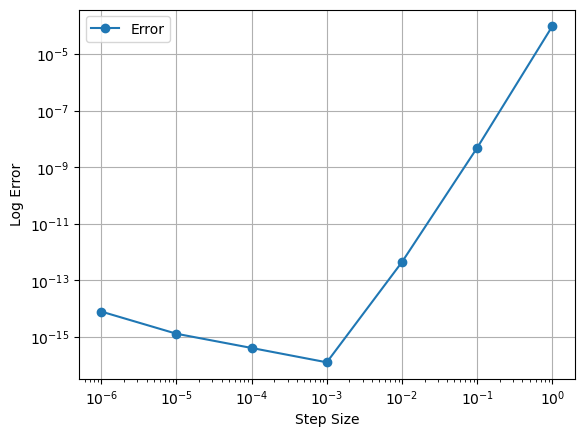

In [129]:
import matplotlib.pyplot as plt

# Convergence

# o_error_list_convergence = jnp.array(o_error_list_convergence)
# o_error_list_convergence = jnp.log(o_error_list_convergence) / jnp.log(10)
# c_error_list_convergence = jnp.array(c_error_list_convergence)
# c_error_list_convergence = jnp.log(c_error_list_convergence)/jnp.log(10)
# plt.plot(step_size_list_convergence, o_error_list_convergence, label = "Error",marker='o')
# plt.plot(step_size_list_convergence, c_error_list_convergence, label = "Error",marker='s')


plt.loglog(step_size_list_convergence, error_list_convergence, label = "Error",marker='o')
# plt.loglog(step_size_list_convergence, c_error_list_convergence, label = "Error",marker='s')

plt.legend()
plt.grid()
plt.xlabel('Step Size')
plt.ylabel('Log Error')